In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, LayerNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import r2_score
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [65]:
# Laste poll-of-polls data
#df = pd.read_csv("../data/all_polls.csv", sep=",", encoding='ISO-8859-1')
#df= pd.read_csv("https://github.com/jensmorten/onesixtynine/blob/JM/data/all_polls.csv", sep=",", encoding='ISO-8859-1')
df = pd.read_csv("https://raw.githubusercontent.com/jensmorten/onesixtynine/JM/data/all_polls.csv", sep=",", encoding='ISO-8859-1')

In [66]:
# Convert to datetime and set the date to the end of the month
df["Dato"] = pd.to_datetime(df["Dato"])

In [67]:
# Sort values and set index
df = df.sort_values("Dato")
df.set_index("Dato", inplace=True)

In [68]:
df_en=df[["Ap","Høyre","Frp","SV","Sp","KrF","Venstre","MDG","Rødt", "Andre"]]

In [69]:
df

,Måling,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre,Year,Month
Dato,,,,,,,,,,,,,
2008-01-09,Verian/TV2,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0,2008,1
2008-01-10,Sentio/BT,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0,2008,1
2008-01-18,Norstat/NRK,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0,2008,1
2008-01-21,InFact/VG,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0,2008,1
2008-01-21,Respons/Aftenp,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0,2008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-05,Verian/TV2,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8,2025,9
2025-09-05,Norstat/NRK / VL / Dagbl.,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1,2025,9
2025-09-06,Norfakta/Nat. / KK,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9,2025,9


In [70]:
df_en.head(20)

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
Dato,,,,,,,,,,
2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
2008-01-24,26.1,17.5,25.4,7.9,6.3,6.0,6.4,0.0,3.2,0.0
2008-01-24,28.0,14.6,24.0,7.1,6.0,7.1,9.5,0.0,2.0,0.0
2008-01-30,28.0,18.8,20.6,10.1,8.0,5.5,6.0,0.0,2.4,0.0
2008-02-02,30.3,16.9,26.0,6.1,5.3,6.2,6.7,0.0,1.2,0.0


In [71]:
df_test=df_en
df_test=df_test.reset_index()

In [72]:
df_test

,Dato,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
0,2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
1,2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2,2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
3,2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
4,2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1858,2025-09-05,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8
1859,2025-09-05,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1
1860,2025-09-06,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
1861,2025-09-06,27.3,14.9,21.3,5.7,6.0,4.7,3.9,6.4,5.3,4.7


In [73]:
df_test["rank"] = df_test.groupby(df_test["Dato"].dt.date).cumcount()

In [74]:
times = pd.to_timedelta([0, 4, 8, 12, 16, 18, 22], unit="h")
df_test["DateTime"] = df_test["Dato"].dt.normalize() + df_test["rank"].map(dict(zip(range(7), times)))

In [75]:
df_test

,Dato,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre,rank,DateTime
0,2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0,0,2008-01-09 00:00:00
1,2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0,0,2008-01-10 00:00:00
2,2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0,0,2008-01-18 00:00:00
3,2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0,0,2008-01-21 00:00:00
4,2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0,1,2008-01-21 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,2025-09-05,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8,0,2025-09-05 00:00:00
1859,2025-09-05,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1,1,2025-09-05 04:00:00
1860,2025-09-06,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9,0,2025-09-06 00:00:00
1861,2025-09-06,27.3,14.9,21.3,5.7,6.0,4.7,3.9,6.4,5.3,4.7,1,2025-09-06 04:00:00


In [76]:
df_test= df_test.drop(columns=["Dato", "rank"]).set_index("DateTime").sort_index()

In [77]:
df_test

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
DateTime,,,,,,,,,,
2008-01-09 00:00:00,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-10 00:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-18 00:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-21 00:00:00,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
2008-01-21 04:00:00,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-09-05 00:00:00,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8
2025-09-05 04:00:00,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1
2025-09-06 00:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9


In [78]:
full_idx = pd.date_range(df_test.index.min(), df_test.index.max(), freq="6h")
df_test = df_test.reindex(full_idx).bfill()

In [79]:
df_test

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
2008-01-09 00:00:00,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-09 06:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-09 12:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-09 18:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-10 00:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-09-05 06:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
2025-09-05 12:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
2025-09-05 18:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
2025-09-06 00:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9


In [80]:
#df_fixed = expand_and_impute(df_en, resample_freq="6H")
df_fixed=df_test.dropna()
# Quick check
print("Any NaNs left?", df_fixed.isna().sum().sum())
print("Row sums sample:", df_fixed.sum(axis=1).head(10).values)

Any NaNs left? 0
Row sums sample: [97.3 96.8 96.8 96.8 96.8 96.7 96.7 96.7 96.7 96.7]


In [124]:
split = int(len(df_en) - 30*6)
train_data = df_en[:split]
val_data   = df_en[split:]

In [126]:
len(val_data)

180

In [127]:
model = VAR(endog=train_data)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [136]:
model_fitted = model.fit(maxlags=30,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Sep, 2025
Time:                     14:35:19
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    6.50965
Nobs:                     1653.00    HQIC:                  0.330717
Log likelihood:          -17719.8    FPE:                  0.0380508
AIC:                     -3.30949    Det(Omega_mle):      0.00717911
--------------------------------------------------------------------
Results for equation Ap
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.Ap               0.135096         0.115931            1.165           0.244
L1.Høyre           -0.095328         0.115143           -0.828           0.408
L1.Frp             -0.141001         0.115285           -1.223         

In [137]:
train_r2_scores = {}
train_mae_scores = {}

for party in ["Ap","Høyre","Frp","SV","Sp","KrF","Venstre","MDG","Rødt", "Andre"]:
    y_true = train_data[party].iloc[model_fitted.k_ar:]
    y_pred = model_fitted.fittedvalues[party]
    train_r2_scores[party] = r2_score(y_true, y_pred)
    train_mae_scores[party] = mean_absolute_error(y_true, y_pred)

print("\n=== Training set metrics ===")
for party in train_r2_scores:
    print(f"{party:7s} | R²: {train_r2_scores[party]:.4f} | MAE: {train_mae_scores[party]:.4f}")



=== Training set metrics ===
Ap      | R²: 0.9187 | MAE: 1.2260
Høyre   | R²: 0.9009 | MAE: 1.2198
Frp     | R²: 0.9049 | MAE: 1.2627
SV      | R²: 0.8515 | MAE: 0.5632
Sp      | R²: 0.9581 | MAE: 0.6683
KrF     | R²: 0.7082 | MAE: 0.4563
Venstre | R²: 0.5915 | MAE: 0.5318
MDG     | R²: 0.9248 | MAE: 0.4025
Rødt    | R²: 0.9160 | MAE: 0.4381
Andre   | R²: 0.8311 | MAE: 0.4376


In [138]:
lag_order = model_fitted.k_ar
forecast_input = train_data.values[-lag_order:]  # last `lag_order` observations from training
forecast = model_fitted.forecast(y=forecast_input, steps=len(val_data))

forecast_df = pd.DataFrame(forecast, index=val_data.index, columns=val_data.columns)


In [139]:
val_r2_scores = {}
val_mae_scores = {}

for party in ["Ap","Høyre","Frp","SV","Sp","KrF","Venstre","MDG","Rødt", "Andre"]:
    y_true = val_data[party]
    y_pred = forecast_df[party]
    val_r2_scores[party] = r2_score(y_true, y_pred)
    val_mae_scores[party] = median_absolute_error(y_true, y_pred)

print("\n=== Validation set metrics ===")
for party in val_r2_scores:
    print(f"{party:7s} | R²: {val_r2_scores[party]:.4f} | MAE: {val_mae_scores[party]:.4f}")


=== Validation set metrics ===
Ap      | R²: 0.3237 | MAE: 2.4445
Høyre   | R²: -2.9346 | MAE: 5.8399
Frp     | R²: -0.5483 | MAE: 4.0697
SV      | R²: 0.3987 | MAE: 0.9960
Sp      | R²: -24.3644 | MAE: 4.0704
KrF     | R²: -1.2689 | MAE: 0.7997
Venstre | R²: -1.1480 | MAE: 1.1071
MDG     | R²: -1.6064 | MAE: 0.7463
Rødt    | R²: -1.9314 | MAE: 1.0280
Andre   | R²: 0.0932 | MAE: 0.8549


In [142]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Split data
split = int(len(df_en) * 0.90)
train_data = df_en[:split]
val_data   = df_en[split:]

# Parties
parties = ["Ap","Høyre","Frp","SV","Sp","KrF","Venstre","MDG","Rødt", "Andre"]

# Compute weights: inverse of mean in training set
party_means = train_data[parties].mean()
weights = 1 / party_means
weights = weights / weights.sum()  # normalize so weights sum to 1 (optional)

# Function to compute weighted MAE for a given maxlags
def evaluate_maxlag(maxlags):
    try:
        model = VAR(endog=train_data)
        model_fitted = model.fit(maxlags=maxlags, method='ols', trend='n')
        lag_order = model_fitted.k_ar
        forecast_input = train_data.values[-lag_order:]
        forecast = model_fitted.forecast(y=forecast_input, steps=len(val_data))
        forecast_df = pd.DataFrame(forecast, index=val_data.index, columns=val_data.columns)

        mae_per_party = []
        for party in parties:
            mae = mean_absolute_error(val_data[party], forecast_df[party])
            mae_per_party.append(mae * weights[party])

        weighted_mae = np.sum(mae_per_party)
        return weighted_mae
    except Exception as e:
        # In case model cannot be fit for this lag
        return np.inf

# Search for best maxlag
results = {}
for lag in range(1, 30):  # you can adjust range
    results[lag] = evaluate_maxlag(lag)

# Find lag with minimum weighted MAE
best_lag = min(results, key=results.get)

print("=== Weighted MAE per maxlag ===")
for lag, score in results.items():
    print(f"maxlags={lag:2d} -> Weighted MAE={score:.6f}")

print(f"\nOptimal maxlags = {best_lag}, with Weighted MAE = {results[best_lag]:.6f}")


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A dat

=== Weighted MAE per maxlag ===
maxlags= 1 -> Weighted MAE=1.933481
maxlags= 2 -> Weighted MAE=1.606411
maxlags= 3 -> Weighted MAE=1.344375
maxlags= 4 -> Weighted MAE=1.207000
maxlags= 5 -> Weighted MAE=1.157406
maxlags= 6 -> Weighted MAE=1.150000
maxlags= 7 -> Weighted MAE=1.168327
maxlags= 8 -> Weighted MAE=1.162873
maxlags= 9 -> Weighted MAE=1.228268
maxlags=10 -> Weighted MAE=1.243137
maxlags=11 -> Weighted MAE=1.213127
maxlags=12 -> Weighted MAE=1.243624
maxlags=13 -> Weighted MAE=1.257709
maxlags=14 -> Weighted MAE=1.257540
maxlags=15 -> Weighted MAE=1.243729
maxlags=16 -> Weighted MAE=1.221174
maxlags=17 -> Weighted MAE=1.238539
maxlags=18 -> Weighted MAE=1.231286
maxlags=19 -> Weighted MAE=1.293264
maxlags=20 -> Weighted MAE=1.325304
maxlags=21 -> Weighted MAE=1.352898
maxlags=22 -> Weighted MAE=1.394911
maxlags=23 -> Weighted MAE=1.425566
maxlags=24 -> Weighted MAE=1.442410
maxlags=25 -> Weighted MAE=1.488630
maxlags=26 -> Weighted MAE=1.490416
maxlags=27 -> Weighted MAE=1.462

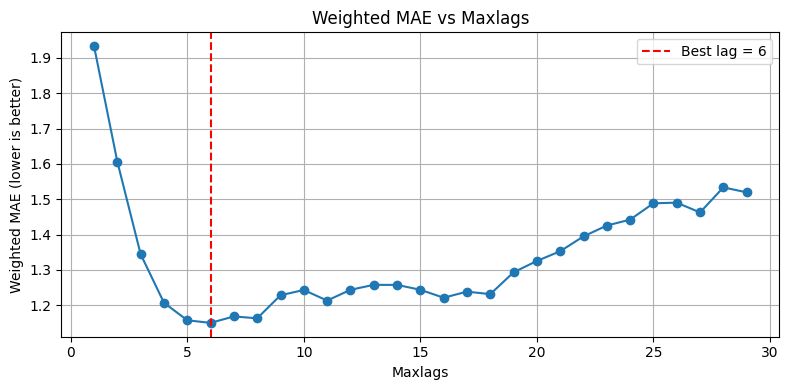

In [143]:
# --- Plot ---
plt.figure(figsize=(8, 4))
plt.plot(list(results.keys()), list(results.values()), marker='o')
plt.axvline(best_lag, color='red', linestyle='--', label=f'Best lag = {best_lag}')
plt.title("Weighted MAE vs Maxlags")
plt.xlabel("Maxlags")
plt.ylabel("Weighted MAE (lower is better)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()